In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from keras import backend
from matplotlib.ticker import MaxNLocator

print(backend._get_available_gpus())
%matplotlib inline

# Constant values
CWD = os.path.abspath(os.getcwd())
TRAIN_CSV = os.path.join(CWD, "train.csv")
TEST_CSV = os.path.join(CWD, "test.csv")
RESULTS_CSV = os.path.join(CWD, "results.csv")
IMG_WIDTH = 28
IMG_HEIGHT = 28
NUM_CHANNELS = 1
NUM_CLASSES = 10
RANDOM_SEED = 2
NUM_EPOCHS = 75
BATCH_SIZE = 128
VAL_SIZE = 0.08
OUTPUT_COLS = ["ImageId", "Label"]

np.random.seed(2)

train_df = pd.read_csv(TRAIN_CSV, index_col=False)
test_df = pd.read_csv(TEST_CSV, index_col=False)

Y_train = train_df["label"]
Y_train = to_categorical(Y_train, num_classes=NUM_CLASSES)

X_train = train_df.drop(columns="label")



['/device:GPU:0']


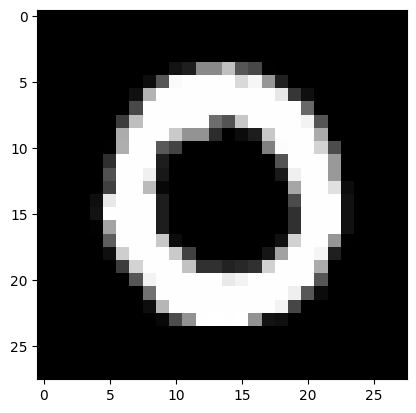

In [2]:
X_train = X_train.values.reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
X_train = X_train/255
ax = plt.imshow(X_train[1], cmap="gray")

In [3]:

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                test_size=VAL_SIZE, random_state=RANDOM_SEED)

In [4]:
model = Sequential()

model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)))

model.add(Conv2D(filters = 128, kernel_size = (5,5), padding = "Same",
                activation="elu"))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size=(5,5), padding = "Same",
                activation="elu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 256, kernel_size=(3,3), padding = "Same",
                activation="elu"))
model.add(BatchNormalization())

model.add(Conv2D(filters = 256, kernel_size=(3,3), padding = "Same",
                activation="elu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="elu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(NUM_CLASSES, activation="softmax"))

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-8, decay=0.0)
loss_function = CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss = loss_function, metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy",
                                            patience = 3,
                                            verbose = 2,
                                            factor = 0.5,
                                            min_lr=0.00001,
                                            mode = "max")

In [5]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

In [6]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                            epochs=NUM_EPOCHS, validation_data=(X_val, Y_val), 
                            verbose = 2, callbacks=[learning_rate_reduction])


#history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE,
#                    epochs=NUM_EPOCHS, validation_data=(X_val, Y_val),
#                    verbose = 2, callbacks=[learning_rate_reduction])

Epoch 1/75


C:\Users\mattw\AppData\Local\Temp\ipykernel_14592\2030602476.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


302/302 - 16s - loss: 0.2355 - accuracy: 0.9291 - val_loss: 2.4812 - val_accuracy: 0.4274 - lr: 0.0010 - 16s/epoch - 52ms/step
Epoch 2/75
302/302 - 8s - loss: 0.0745 - accuracy: 0.9762 - val_loss: 0.0441 - val_accuracy: 0.9863 - lr: 0.0010 - 8s/epoch - 26ms/step
Epoch 3/75
302/302 - 8s - loss: 0.0581 - accuracy: 0.9817 - val_loss: 0.0548 - val_accuracy: 0.9842 - lr: 0.0010 - 8s/epoch - 26ms/step
Epoch 4/75
302/302 - 8s - loss: 0.0487 - accuracy: 0.9843 - val_loss: 0.0343 - val_accuracy: 0.9902 - lr: 0.0010 - 8s/epoch - 26ms/step
Epoch 5/75
302/302 - 8s - loss: 0.0411 - accuracy: 0.9873 - val_loss: 0.0350 - val_accuracy: 0.9890 - lr: 0.0010 - 8s/epoch - 26ms/step
Epoch 6/75
302/302 - 8s - loss: 0.0373 - accuracy: 0.9887 - val_loss: 0.0288 - val_accuracy: 0.9908 - lr: 0.0010 - 8s/epoch - 26ms/step
Epoch 7/75
302/302 - 8s - loss: 0.0320 - accuracy: 0.9903 - val_loss: 0.0329 - val_accuracy: 0.9911 - lr: 0.0010 - 8s/epoch - 26ms/step
Epoch 8/75
302/302 - 8s - loss: 0.0313 - accuracy: 0.9901

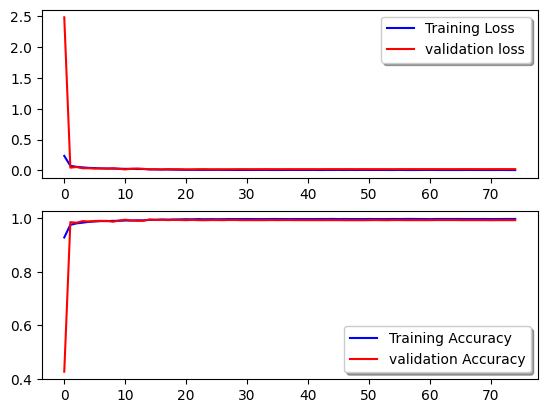

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color = 'b', label = "Training Loss")
ax[0].plot(history.history['val_loss'], color = 'r', label="validation loss")
ax[0].xaxis.set_major_locator(MaxNLocator(integer = True))
ax[0].legend(loc='best', shadow = True)

ax[1].plot(history.history['accuracy'], color = 'b', label = "Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color = 'r', label="validation Accuracy")
ax[1].xaxis.set_major_locator(MaxNLocator(integer = True))
legend = ax[1].legend(loc='best', shadow = True)

In [8]:
X_test = test_df.values.reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
X_test = X_test/255

one_hot_predictions = model.predict(X_test, batch_size=BATCH_SIZE)
predictions = np.argmax(one_hot_predictions, axis = -1)

results_df = pd.DataFrame(columns=["ImageId", "Label"])
results_df["ImageId"] = list(range(1, len(predictions) + 1))
results_df["Label"] = predictions

results_df.to_csv(RESULTS_CSV, index=False)



219/219 [==============================] - 1s 5ms/step
